# Schéma de Lax-Friedrichs pour l'advection

Nous considérons le problème posé sur un domaine périodique
$$
\left\lbrace\begin{aligned}
&\partial_t u + a \partial_x u = 0, && t>0, 0\leq x\leq 1,\\
&u(0, x) = u^0(x), && 0\leq x\leq 1,\\
&u(t, 0) = u(t, 1), && t\geq 0.
\end{aligned}\right.
$$

In [12]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Le maillage

Le maillage en espace est constitué de $N$ points équi-répartis entre 0 et 1. Nous noterons
$$ x_j = h(j+1/2), \qquad 0\leq j< N,$$
avec $h=1/N$.

**Question**

> * Proposez une fonction `mesh` qui prend en argument un entier $N$ et qui retourne un `double` $h$ pour le pas du maillage et un `ndarray` de taille $N$ contenant les valeurs $x_j$ pour $0\leq j<N$.
> * Représentez le maillage obtenu avec $N=10$ en utilisant la commande `scatter`.

In [13]:
np.arange(0, 1, 1/N)

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667])

In [14]:
np.linspace(0, 1, N, endpoint=False, retstep=True)

(array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
        0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
        0.83333333, 0.91666667]),
 0.08333333333333333)

In [15]:
np.linspace(0,N-1,N)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [16]:
def mesh(N):
    """ 
    h = 1/N #pas du maillage
    m = np.arange(0, 1, 1/N)
    m+=0.5*h"""
   
    """h = 1/N
    m = np.linspace(0,N-1,N) # car n exclu
    #print(m)
    m += 0.5
    m*=h
    #print(m)"""
    
    
    """construit le maillage pour les différences finies"""
    m, h = np.linspace(0, 1, N, endpoint=False, retstep=True)
    m += .5*h
    
    return h,m

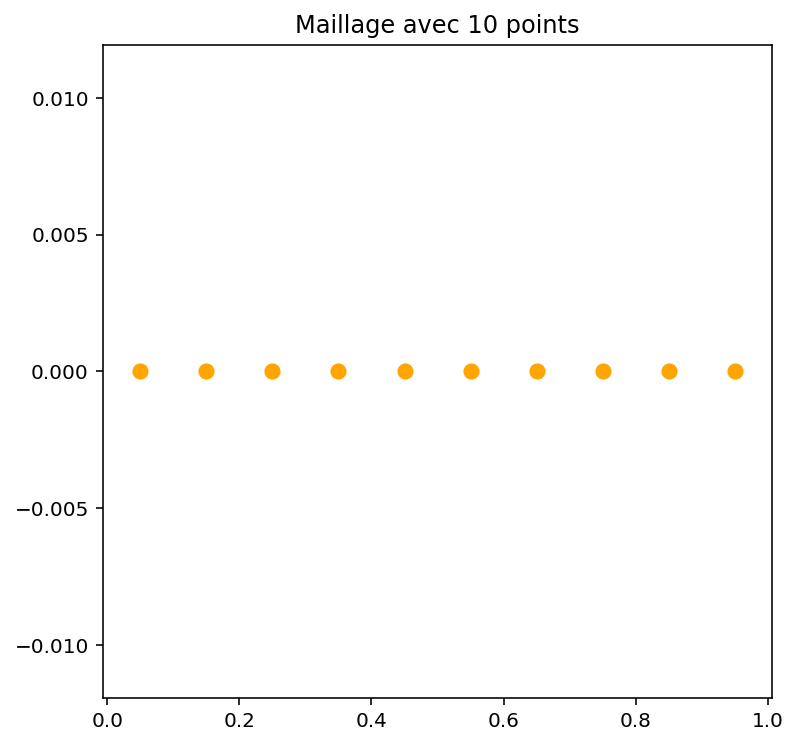

In [17]:
N = 10
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
h, m = mesh(N)
ax.scatter(m, np.zeros(m.shape), s=50, c='orange')
ax.set_title(f'Maillage avec {N} points');

## La donnée initiale

Pour fonction initiale $u^0$, nous souhaitons pouvoir tester le schéma avec différentes régularités (une fonction discontinue, continue, dérivable, $\ldots$).

**Question**

> * Proposez une fonction `init` qui prend en argument un `ndarray` $x$ et un `integer` $k$ et qui retourne un `ndarray` $y$ tel que $y_i=\phi^k(x_i)$ où $\phi^k$ est définie par
$$
\phi^k (x) = \boldsymbol{1}_{[x_l,x_r]}(x) P^{k+1}(x),
\quad
P(x) = \frac{4}{(x_r-x_l)^2} (x-x_l)(x_r-x),
$$
avec $x_l=1/4$ et $x_r=1/2$.
> * Tracez dans un même graphique les différentes données initiales pour $k\in\lbrace -1, 0, 1, 2\rbrace$.

In [18]:
a = [1,1,1,1,1,1,1]
b = np.empty(len(a))
print(b)

[-0.015 -0.01  -0.005  0.     0.005  0.01   0.015]


In [19]:
def init(x,k):
    
    y = np.zeros(len(x))
    xl, xr = 0.25, 0.5
    compt=0
    for xi in x:
        
        p = (4/(xr-xl)**2) *(xi-xl)*(xr-xi)
        #p = 4/(xr-xl)**2 * (xi-xl)*(xr-xi)
        if(xi>=xl and xi<=xr):
            y[compt] = p**(k+1)
        else:
            y[compt] = 0
        compt+=1
    return y

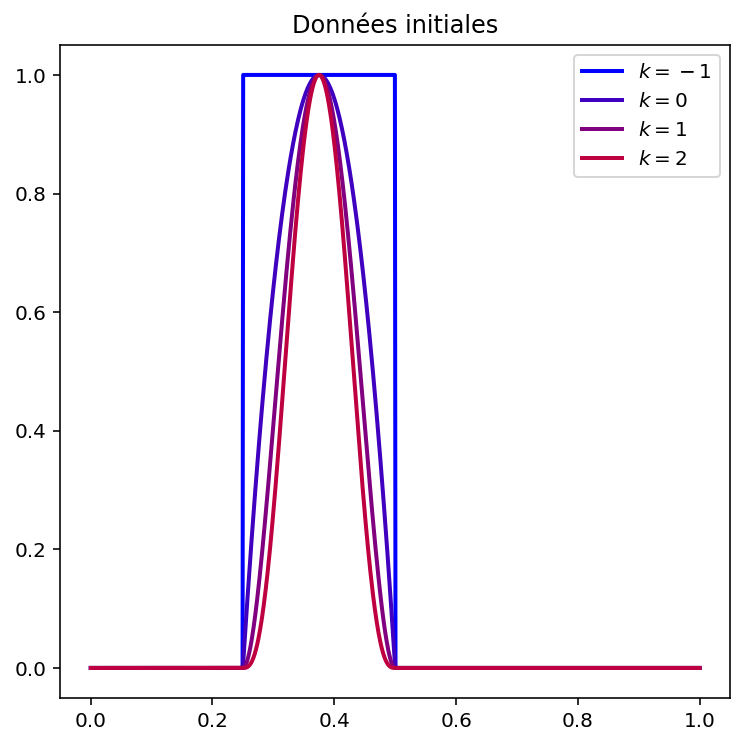

In [20]:
N = 1000
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
h, m = mesh(N)
liste_k = [-1, 0, 1, 2]
n = len(liste_k)
for i, k in enumerate(liste_k):
    ax.plot(m, init(m, k), color=(i/n, 0, 1-i/n), linewidth=2, label=f'$k={k}$')
ax.set_title(f'Données initiales')
ax.legend();

## Le schéma de Lax-Friedrichs

Nous allons à présent implémenter le schéma de Lax-Fridrichs défini par
$$
v_j^{n+1} = \frac{1}{2} (1+\beta) v_{j-1}^n + \frac{1}{2} (1-\beta) v_{j+1}^n,
$$
avec $\beta=ak/h$, où $k$ est le pas de temps et $h$ le pas d'espace.

**Question**

> * Proposez une fonction `lax_friedrichs` qui prend en argument un `ndarray` $v$, un `double` $\beta$ et qui retourne un `ndarray` $w$ calculé après un pas de temps du schéma de Lax-Friedrichs. Vous n'oublierez pas de traiter les termes de bord grâce à la condition de périodicité.
> * Testez le schéma proposé en traçant la solution approchée après un tour, 2 tours, 3 tours. Vous choisirez pour cela convenablement le paramètre $k$ en fonction de $h$ et de $a$. Faites varier la valeur de $ak/h$ afin de mesurer l'impact de la condition CFL.

In [21]:
kk = 2 
N = 200
h, m = mesh(N)
v = init(m, kk)


In [22]:
a = np.array([1,2,3,4,5,6,7,8])
print(a[:]) # tout
print(a[1:]) # premier element exclu donc décalé vers la droite
print(a[:-1]) # dernier element exclu donc décalé vers la gauche

[1 2 3 4 5 6 7 8]
[2 3 4 5 6 7 8]
[1 2 3 4 5 6 7]


In [23]:
print(a[:1]) 
print(a[-1:]) 

[1]
[8]


In [24]:
v = np.array([0,1,2,3,4,5])
vp, vm = np.empty(v.shape), np.empty(v.shape)
vp[:-1] = v[1:]
vm[1:] = v[:-1]
# conditions aux limites
vp[-1] = v[0]
vm[0] = v[-1]

print(vp) 
print(vm) # 0 en j-1 

[1. 2. 3. 4. 5. 0.]
[5. 0. 1. 2. 3. 4.]


In [25]:
def lax_friedrichs(v,beta):
    vp, vm = np.zeros(v.shape), np.zeros(v.shape)
    
    """
    for i in range(len(v)-1):
        vp[i] = v[i+1]
        
    vp[-1] = v[0]
     
    
    for i in range(1,len(v)):
        vm[i] = v[i-1]
    
    vm[0] = v[-1]"""

    vp[:-1] = v[1:] 
    vm[1:] = v[:-1]
    
    vp[-1] = v[0]
    vm[0] = v[-1]
    alpham, alphap = .5*(1+beta), .5*(1-beta)
    
    w = vp*alphap + vm*alpham
    
    return w

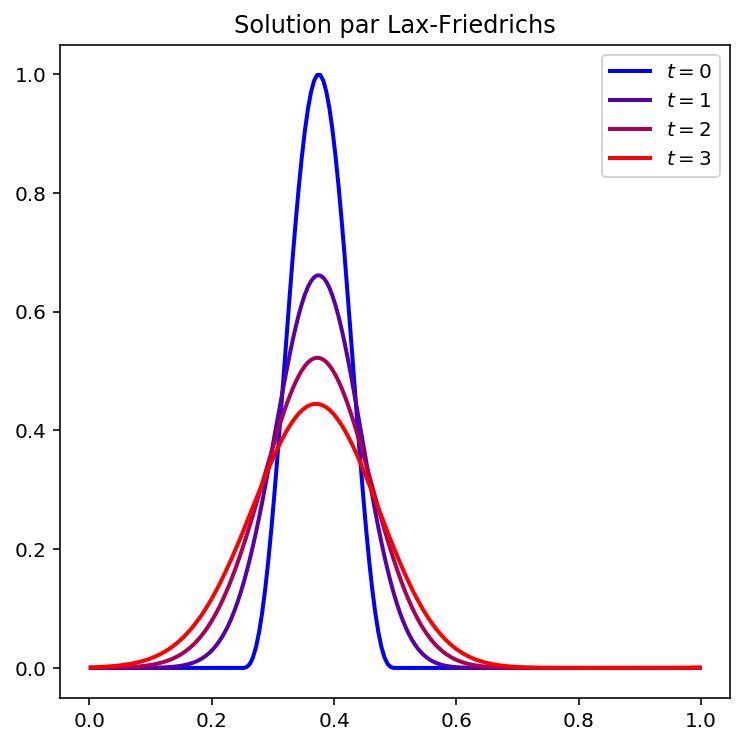

In [26]:
a = 1  # vitesse
kk = 2  # paramètre de régularité
N = 200  # nombre de points pour le maillage
beta = 0.75  # paramètre pour la condition CFL
nb_tours = 3  # nombre de tours

h, m = mesh(N)  # maillage
k = beta/abs(a)*h  # pas de temps
nb_pas = int(1/(a*k))  # nombre de pas de temps pour faire un tour

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

t = 0.
v = init(m, kk)

ax.plot(m, v, color=(0, 0, 1), linewidth=2, label=f'$t={t:1.0f}$')
for nt in range(1, nb_tours+1):
    for _ in range(nb_pas):
        v = lax_friedrichs(v, beta)
        t += k
    ax.plot(m, v, color=(nt/nb_tours, 0, 1-nt/nb_tours), linewidth=2, label=f'$t={t:1.0f}$')
ax.set_title(f'Solution par Lax-Friedrichs')
ax.legend();

Nous allons à présent visualiser la convergence du schéma. Nous choisirons $\beta=0.75$ et des pas d'espace $h$ de la forme $h_n=2^{-n}$ pour $n$ allant de 4 à 11. Pour $h=h_n$, nous noterons $e_n$ la norme infinie de l'erreur (différence entre la solution exacte et la solution approchée) au bout d'un tour.

**Question**

> * Tracez le logarithme de $e_n$ en fonction de $h_n$.
> * Que pouvez-vous en conclure ?

la pente vaut 0.9868724089740393


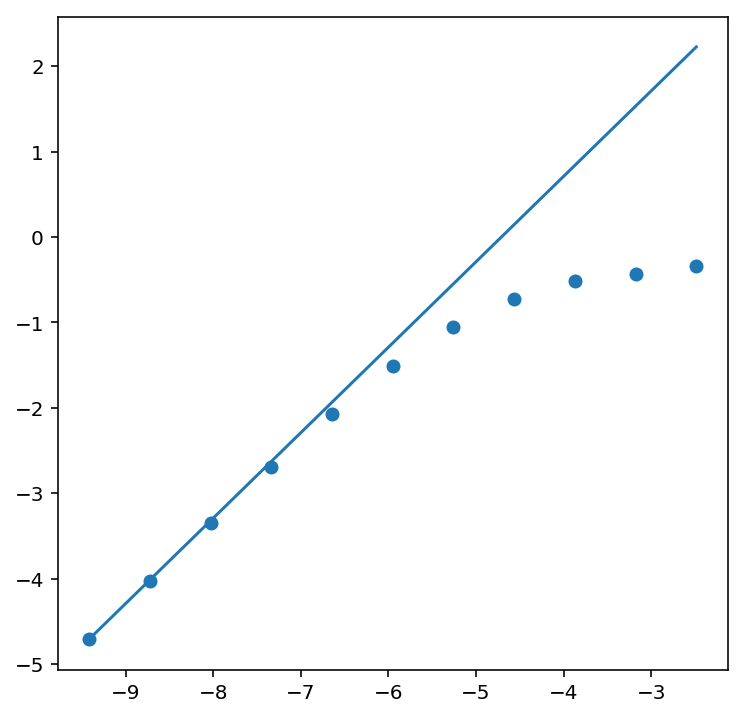

In [27]:
a = 1  # vitesse
kk = 2  # paramètre de régularité
beta = 0.75

liste_h = []
liste_e = []

for n in range(2,13):

    N = 3*2**n  # nombre de points pour le maillage
    beta = 0.75  # paramètre pour la condition CFL
    nb_tours = 3  # nombre de tours

    h, m = mesh(N)  # maillage
    k = beta/abs(a)*h  # pas de temps
    nb_pas = int(1/(a*k))  # nombre de pas de temps pour faire un tour

    t = 0.
    v = init(m,kk)

    for _ in range(nb_pas):
        v = lax_friedrichs(v,beta)
        t += k
    en = np.linalg.norm(v -init(m,kk), np.inf)
    liste_h.append(np.log(h))
    liste_e.append(np.log(en))
    #print(f"L'erreur vant {en}")
    #print(f"L'erreur pour h = {h:10.3e} vaut {en:10.3e}")

#calcul de la pente
p = ((liste_e[-1])- (liste_e[-2])) / (liste_h[-1]-liste_h[-2])
print(f"la pente vaut {p}")
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(liste_h, liste_e)
ax.plot(liste_h, (liste_h-liste_h[-1]+liste_e[-1]))

pour faire 1 tour, il faut attendre T = 1/a = 1 
combien dce pas de temps qui valent k: nk =T => n = T/k = 1/(ak)
k = beta/a *h => n = 1/(beta*h) = 4/(3/hy)
h = 1/N => n = 4N/3

||eh||inifini <= C*h**p

$ \Vert eh \Vert\infty \leq Ch^p $

$ \log\Vert eh \Vert\infty \leq \log(C) + p\log(h) $